In [ ]:
!pip install numpy pandas scipy matplotlib tensorflow keras

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

project_path = '/content/drive/MyDrive/MSc SS/8th Sem/20XW87 - Data Mining Lab/DTW-Augmentation'

import sys
sys.path.append(f'{project_path}')

Mounted at /content/drive


**DTW**

---



This code contains the implementation of the Dynamic Time Warping algorithm

In [ ]:
import numpy as np
import sys

def dynamic_time_warping(x: np.ndarray, y: np.ndarray, w: float = -1):
    x = np.atleast_2d(x)
    y = np.atleast_2d(y)

    if x.ndim == 1:
        x = x[:, np.newaxis]
    if y.ndim == 1:
        y = y[:, np.newaxis]

    if len(x) > len(y):
        x, y = y, x

    lx, ly = len(x), len(y)
    r, c = lx + 1, ly + 1

    w = max(1, int(w * max(lx, ly))) if w >= 0 else max(lx, ly)

    D = np.zeros((r, c), dtype=np.float64)
    D[0, 1:] = sys.float_info.max
    D[1:, 0] = sys.float_info.max

    dist = np.square(x[:, np.newaxis] - y).sum(axis=2)
    D[1:, 1:] = dist

    for i in range(1, r):
        j_start = max(1, i - w)
        j_stop = min(c, i + w + 1)
        if i - w - 1 >= 0:
            D[i, i - w - 1] = sys.float_info.max

        for j in range(j_start, j_stop):
            D[i, j] += min(D[i - 1, j], D[i, j - 1], D[i - 1, j - 1])

        if j_stop < c:
            D[i, j_stop] = sys.float_info.max

    return np.sqrt(D[lx, ly]), D


Utilities used

---



**Constants**

In [ ]:
from dba import dba

from distances.dtw.dtw import dynamic_time_warping as dtw

from augment import get_weights_average_selected

# UNIVARIATE_DATASET_NAMES = ['50words','Adiac','ArrowHead','Beef','BeetleFly',
#                             'BirdChicken','Car','CBF','ChlorineConcentration',
#                             'CinC_ECG_torso','Coffee','Computers','Cricket_X',
#                             'Cricket_Y','Cricket_Z','DiatomSizeReduction',
#                             'DistalPhalanxOutlineAgeGroup',
#                             'DistalPhalanxOutlineCorrect','DistalPhalanxTW',
#                             'Earthquakes','ECG200','ECG5000','ECGFiveDays',
#                             'ElectricDevices','FaceAll','FaceFour','FacesUCR',
#                             'FISH','FordA','FordB','Gun_Point','Ham',
#                             'HandOutlines','Haptics','Herring','InlineSkate',
#                             'InsectWingbeatSound','ItalyPowerDemand',
#                             'LargeKitchenAppliances','Lighting2','Lighting7',
#                             'MALLAT','Meat','MedicalImages',
#                             'MiddlePhalanxOutlineAgeGroup',
#                             'MiddlePhalanxOutlineCorrect','MiddlePhalanxTW',
#                             'MoteStrain','NonInvasiveFatalECG_Thorax1',
#                             'NonInvasiveFatalECG_Thorax2','OliveOil','OSULeaf',
#                             'PhalangesOutlinesCorrect','Phoneme','Plane',
#                             'ProximalPhalanxOutlineAgeGroup',
#                             'ProximalPhalanxOutlineCorrect',
#                             'ProximalPhalanxTW','RefrigerationDevices',
#                             'ScreenType','ShapeletSim','ShapesAll',
#                             'SmallKitchenAppliances','SonyAIBORobotSurface',
#                             'SonyAIBORobotSurfaceII','StarLightCurves',
#                             'Strawberry','SwedishLeaf','Symbols',
#                             'synthetic_control','ToeSegmentation1',
#                             'ToeSegmentation2','Trace','TwoLeadECG',
#                             'Two_Patterns','UWaveGestureLibraryAll',
#                             'uWaveGestureLibrary_X','uWaveGestureLibrary_Y',
#                             'uWaveGestureLibrary_Z','wafer','Wine',
#                             'WordsSynonyms','Worms','WormsTwoClass','yoga']

UNIVARIATE_DATASET_NAMES = ['BirdChicken','Meat']

UNIVARIATE_ARCHIVE_NAMES = ['UCR_TS_Archive_2015']

AVERAGING_ALGORITHMS = {'dba':dba}

DISTANCE_ALGORITHMS = {'dtw': dtw}

DTW_PARAMS = {'w':-1} # warping window should be given in percentage (negative means no warping window)

DISTANCE_ALGORITHMS_PARAMS = {'dtw':DTW_PARAMS}

MAX_PROTOTYPES_PER_CLASS = 5

WEIGHTS_METHODS = {'as':get_weights_average_selected }


Utils


In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib
matplotlib.use('pdf')
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import LabelEncoder

import operator
from scipy.stats import wilcoxon

from utils.constants import UNIVARIATE_DATASET_NAMES as DATASET_NAMES
from utils.constants import UNIVARIATE_ARCHIVE_NAMES as ARCHIVE_NAMES
from utils.constants import MAX_PROTOTYPES_PER_CLASS

def zNormalize(x):
    x_mean = x.mean(axis=0) # mean for each dimension of time series x
    x_std = x.std(axis = 0) # std for each dimension of time series x
    x = (x - x_mean)/(x_std)
    return x

def readucr(filename):
    data = np.loadtxt(filename, delimiter = ',')
    Y = data[:,0]
    X = data[:,1:]
    return X, Y

def check_if_file_exits(file_name):
    return os.path.exists(file_name)

def create_directory(directory_path):
    if os.path.exists(directory_path):
        return None
    else:
        try:
            os.makedirs(directory_path)
        except:
            # in case another machine created the path meanwhile
            return None
        return directory_path

def transform_labels(y_train,y_test):
    """
    Transform label to min equal zero and continuous
    For example if we have [1,3,4] --->  [0,1,2]
    """
    # init the encoder
    encoder = LabelEncoder()
    # concat train and test to fit
    y_train_test = np.concatenate((y_train,y_test),axis =0)
    # fit the encoder
    encoder.fit(y_train_test)
    # transform to min zero and continuous labels
    new_y_train_test = encoder.transform(y_train_test)
    # resplit the train and test
    new_y_train = new_y_train_test[0:len(y_train)]
    new_y_test = new_y_train_test[len(y_train):]
    return new_y_train, new_y_test

def read_all_datasets(root_dir,archive_name, sort_dataset_name = False):
    datasets_dict = {}

    dataset_names_to_sort = []

    for dataset_name in DATASET_NAMES:
        file_name = root_dir+archive_name+'/'+dataset_name+'/'+dataset_name
        x_train, y_train = readucr(file_name+'_TRAIN')
        x_test, y_test = readucr(file_name+'_TEST')
        datasets_dict[dataset_name] = (x_train.copy(),y_train.copy(),x_test.copy(),y_test.copy())
        dataset_names_to_sort.append((dataset_name,len(x_train)))

    item_getter = 1
    if sort_dataset_name == True:
        item_getter = 0
    dataset_names_to_sort.sort(key=operator.itemgetter(item_getter))

    for i in range(len(DATASET_NAMES)):
        DATASET_NAMES[i] = dataset_names_to_sort[i][0]

    return datasets_dict

def calculate_metrics(y_true, y_pred,duration,clustering=False):
    """
    Return a data frame that contains the precision, accuracy, recall and the duration
    For clustering it applys the adjusted rand index
    """
    if clustering == False:
        res = pd.DataFrame(data = np.zeros((1,5),dtype=float), index=[0],
            columns=['precision','accuracy','error','recall','duration'])
        res['precision'] = precision_score(y_true,y_pred,average='macro')
        res['accuracy'] = accuracy_score(y_true,y_pred)
        res['recall'] = recall_score(y_true,y_pred,average='macro')
        res['duration'] = duration
        res['error'] = 1-res['accuracy']
        return res
    else:
        res = pd.DataFrame(data = np.zeros((1,2),dtype=float), index=[0],
            columns=['ari','duration'])
        res['duration']=duration
        res['ari'] = adjusted_rand_score(y_pred,y_true)
        return res

def dataset_is_ready_to_plot(df_res,dataset_name,archive_name,array_algorithm_names):
    for algorithm_name in array_algorithm_names:
                # if any algorithm algorithm is not finished do not plot
                if not any(df_res.loc[(df_res['dataset_name']==dataset_name) \
                            & (df_res['archive_name']==archive_name)] \
                            ['algorithm_name']==algorithm_name)\
                                       or (df_res.loc[(df_res['dataset_name']==dataset_name) \
                            & (df_res['archive_name']==archive_name)\
                            & (df_res['algorithm_name']==algorithm_name)]\
                                       ['nb_prototypes'].max()!=MAX_PROTOTYPES_PER_CLASS):
                    return False
    return True

def init_empty_df_metrics():
    return pd.DataFrame(data = np.zeros((0,5),dtype=float), index=[],
        columns=['precision','accuracy','error','recall','duration'])

def get_df_metrics_from_avg(avg_df_metrics):
    res = pd.DataFrame(data = np.zeros((1,5),dtype=float), index=[0],
        columns=['precision','accuracy','error','recall','duration'])
    res['accuracy'] = avg_df_metrics['accuracy'].mean()
    res['precision'] = avg_df_metrics['precision'].mean()
    res['error'] = avg_df_metrics['error'].mean()
    res['recall'] = avg_df_metrics['recall'].mean()
    res['duration'] = avg_df_metrics['duration'].mean()
    return res

def get_df_metrics_from_avg_data_cluster(avg_df_metrics):
    res = pd.DataFrame(data = np.zeros((1,2),dtype=float), index=[0],
        columns=['ari','duration'])
    res['ari'] = avg_df_metrics['ari'].mean()
    res['duration'] = avg_df_metrics['duration'].mean()
    return res

def read_dataset(root_dir,archive_name,dataset_name):
    datasets_dict = {}

    file_name = root_dir+'/'+archive_name+'/'+dataset_name+'/'+dataset_name
    x_train, y_train = readucr(file_name+'_TRAIN')
    x_test, y_test = readucr(file_name+'_TEST')
    datasets_dict[dataset_name] = (x_train.copy(),y_train.copy(),x_test.copy(),
        y_test.copy())

    return datasets_dict

def plot_epochs_metric(hist, file_name, metric='loss'):
    plt.figure()
    plt.plot(hist.history[metric])
    plt.plot(hist.history['val_'+metric])
    plt.title('model '+metric)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.savefig(file_name)
    plt.close()

def save_logs(output_directory, hist, y_pred, y_true,duration ):
    hist_df = pd.DataFrame(hist.history)
    hist_df.to_csv(output_directory+'history.csv', index=False)

    df_metrics = calculate_metrics(y_true,y_pred, duration)
    df_metrics.to_csv(output_directory+'df_metrics.csv', index=False)

    index_best_model = hist_df['loss'].idxmin()
    row_best_model = hist_df.loc[index_best_model]

    df_best_model = pd.DataFrame(data = np.zeros((1,6),dtype=float) , index = [0],
        columns=['best_model_train_loss', 'best_model_val_loss', 'best_model_train_acc',
        'best_model_val_acc', 'best_model_learning_rate','best_model_nb_epoch'])

    df_best_model['best_model_train_loss'] = row_best_model['loss']
    df_best_model['best_model_val_loss'] = row_best_model['val_loss']
    df_best_model['best_model_train_acc'] = row_best_model['accuracy']
    df_best_model['best_model_val_acc'] = row_best_model['val_accuracy']
    df_best_model['best_model_learning_rate'] = row_best_model['learning_rate']
    df_best_model['best_model_nb_epoch'] = index_best_model

    df_best_model.to_csv(output_directory+'df_best_model.csv', index=False)

    # for FCN there is no hyperparameters fine tuning - everything is static in code

    # plot losses
    plot_epochs_metric(hist, output_directory+'epochs_loss.png')

# visualizations pairwise plots for AALTD 2018

def generate_results_csv(output_file_name, root_dir,root_dir_dataset_archive, add_bake_off=True):
    res = pd.DataFrame(data=np.zeros((0, 7), dtype=float), index=[],
                       columns=['classifier_name', 'archive_name', 'dataset_name',
                                'precision', 'accuracy', 'recall', 'duration'])
    CLASSIFIERS = ['resnet','resnet_augment','ensemble']
    ITERATIONS = 1
    for classifier_name in CLASSIFIERS:
        for archive_name in ARCHIVE_NAMES:
            datasets_dict = read_all_datasets(root_dir_dataset_archive, archive_name)
            for it in range(ITERATIONS):
                curr_archive_name = archive_name
                if it != 0:
                    curr_archive_name = curr_archive_name + '_itr_' + str(it)
                for dataset_name in datasets_dict.keys():
                    output_dir = root_dir + '/results/' + classifier_name + '/' \
                                 + curr_archive_name + '/' + dataset_name + '/' + 'df_metrics.csv'
                    if not os.path.exists(output_dir):
                        continue
                    df_metrics = pd.read_csv(output_dir)
                    df_metrics['classifier_name'] = classifier_name
                    df_metrics['archive_name'] = archive_name
                    df_metrics['dataset_name'] = dataset_name
                    res = pd.concat((res, df_metrics), axis=0, sort=False)

    res.to_csv(root_dir + output_file_name, index=False)
    # aggreagte the accuracy for iterations on same dataset
    res = pd.DataFrame({
        'accuracy': res.groupby(
            ['classifier_name', 'archive_name', 'dataset_name'])['accuracy'].mean()
    }).reset_index()

    return res

def plot_pairwise(root_dir,root_dir_dataset_archive, classifier_name_1, classifier_name_2,
                  res_df=None, title='', fig=None, color='green', label=None):
    if fig is None:
        plt.figure()
    else:
        plt.figure(fig)

    if res_df is None:
        res_df = generate_results_csv('results.csv', root_dir,root_dir_dataset_archive)

    sorted_df = res_df.loc[(res_df['classifier_name'] == classifier_name_1) | \
                           (res_df['classifier_name'] == classifier_name_2)]. \
        sort_values(['classifier_name', 'archive_name', 'dataset_name'])
    # number of classifier we are comparing is 2 since pairwise
    m = 2
    # get max nb of ready datasets
    # count the number of tested datasets per classifier
    df_counts = pd.DataFrame({'count': sorted_df.groupby(
        ['classifier_name']).size()}).reset_index()
    # get the maximum number of tested datasets
    max_nb_datasets = df_counts['count'].max()
    min_nb_datasets = df_counts['count'].min()
    # both classifiers should have finished
    assert (max_nb_datasets == min_nb_datasets)

    data = np.array(sorted_df['accuracy']).reshape(m, max_nb_datasets).transpose()

    # concat the dataset name and the archive name to put them in the columns s
    sorted_df['archive_dataset_name'] = sorted_df['archive_name'] + '__' + \
                                        sorted_df['dataset_name']
    # create the data frame containg the accuracies
    df_data = pd.DataFrame(data=data, columns=np.sort([classifier_name_1, classifier_name_2]),
                           index=np.unique(sorted_df['archive_dataset_name']))

    # # assertion
    # p1 = float(sorted_df.loc[(sorted_df['classifier_name'] == classifier_name_1) &
    #                          (sorted_df['dataset_name'] == 'Beef')]['accuracy'])
    # p2 = float(df_data[classifier_name_1]['UCR_TS_Archive_2015__Beef'])
    # assert (p1 == p2)

    x = np.arange(start=0, stop=1, step=0.01)
    plt.xlim(xmax=1.02, xmin=0.0)
    plt.ylim(ymax=1.02, ymin=0.0)

    plt.scatter(x=df_data[classifier_name_1], y=df_data[classifier_name_2], color='blue')
    # c=sorted_df['theme_colors'])
    plt.xlabel('without data augmentation', fontsize='large')
    plt.ylabel('with data augmentation', fontsize='large')
    plt.plot(x, x, color='black')
    # plt.legend(loc='upper left')
    plt.title(title)

    uniq, counts = np.unique(df_data[classifier_name_1] < df_data[classifier_name_2], return_counts=True)
    print('Wins', counts[-1])

    uniq, counts = np.unique(df_data[classifier_name_1] == df_data[classifier_name_2], return_counts=True)
    print('Draws', counts[-1])

    uniq, counts = np.unique(df_data[classifier_name_1] > df_data[classifier_name_2], return_counts=True)
    print('Losses', counts[-1])

    p_value = wilcoxon(df_data[classifier_name_1], df_data[classifier_name_2], zero_method='pratt')[1]
    print(p_value)

    plt.savefig(root_dir + '/' + classifier_name_1 + '-' + classifier_name_2 + '_' + title + '.pdf'
                , bbox_inches='tight')

**DBA**

---



Utilizes the DTW algorithm and assigns weights

In [ ]:
import numpy as np
import utils

def calculate_dist_matrix(tseries, dist_fun, dist_fun_params):
    N = len(tseries)
    pairwise_dist_matrix = np.zeros((N,N), dtype = np.float64)
    # pre-compute the pairwise distance
    for i in range(N-1):
        x = tseries[i]
        for j in range(i+1,N):
            y = tseries[j]
            dist = dist_fun(x,y,**dist_fun_params)[0]
            # because dtw returns the sqrt
            dist = dist*dist
            pairwise_dist_matrix[i,j] = dist
            # dtw is symmetric
            pairwise_dist_matrix[j,i] = dist
        pairwise_dist_matrix[i,i] = 0
    return pairwise_dist_matrix

def medoid(tseries, dist_fun, dist_fun_params):
    """
    Calculates the medoid of the given list of MTS
    :param tseries: The list of time series
    """
    N = len(tseries)
    if N == 1 :
        return 0,tseries[0]
    pairwise_dist_matrix = calculate_dist_matrix(tseries, dist_fun,
                                                 dist_fun_params)

    sum_dist = np.sum(pairwise_dist_matrix, axis = 0)
    min_idx = np.argmin(sum_dist)
    med = tseries[min_idx]
    return min_idx, med

def _dba_iteration(tseries, avg, dist_fun, dist_fun_params,weights):
    """
    Perform one weighted dba iteration and return the new average
    """
    # the number of time series in the set
    n = len(tseries)
    # length of the time series
    ntime = avg.shape[0]
    # number of dimensions (useful for MTS)
    num_dim = avg.shape[1]
    # array containing the new weighted average sequence
    new_avg = np.zeros((ntime,num_dim),dtype=np.float64)
    # array of sum of weights
    sum_weights = np.zeros((ntime,num_dim),dtype=np.float64)
    # loop the time series
    for s in range(n):
        series = tseries[s]
        dtw_dist, dtw = dist_fun(avg, series, **dist_fun_params)

        i = ntime
        j = series.shape[0]
        while i >= 1 and j >= 1:
            new_avg[i-1] += series[j-1]*weights[s]
            sum_weights[i-1] += weights[s]

            a = dtw[i - 1, j - 1]
            b = dtw[i, j - 1]
            c = dtw[i - 1, j]
            if a < b:
                if a < c:
                    # a is the minimum
                    i -= 1
                    j -= 1
                else:
                    # c is the minimum
                    i -=1
            else:
                if b < c:
                    # b is the minimum
                    j -= 1
                else:
                    # c is the minimum
                    i -= 1
    # update the new weighted avgerage
    new_avg = new_avg/sum_weights

    return new_avg

def dba(tseries, max_iter =10, verbose=False, init_avg_method = 'medoid',
        init_avg_series = None, distance_algorithm = 'dtw', weights=None):
    """
    Computes the Dynamic Time Warping (DTW) Barycenter Averaging (DBA) of a
    group of Multivariate Time Series (MTS).
    :param tseries: A list containing the series to be averaged, where each
        MTS has a shape (l,m) where l is the length of the time series and
        m is the number of dimensions of the MTS - in the case of univariate
        time series m should be equal to one
    :param max_iter: The maximum number of iterations for the DBA algorithm.
    :param verbose: If true, then provide helpful output.
    :param init_avg_method: Either:
        'random' the average will be initialized by a random time series,
        'medoid'(default) the average will be initialized by the medoid of tseries,
        'manual' the value in init_avg_series will be used to initialize the average
    :param init_avg_series: this will be taken as average initialization if
        init_avg_method is set to 'manual'
    :param distance_algorithm: Determine which distance to use when aligning
        the time series
    :param weights: An array containing the weights to calculate a weighted dba
        (NB: for MTS each dimension should have its own set of weights)
        expected shape is (n,m) where n is the number of time series in tseries
        and m is the number of dimensions
    """
    # get the distance function
    dist_fun = utils.constants.DISTANCE_ALGORITHMS[distance_algorithm]
    # get the distance function params
    dist_fun_params = utils.constants.DISTANCE_ALGORITHMS_PARAMS[distance_algorithm]
    # check if given dataset is empty
    if len(tseries)==0:
        # then return a random time series because the average cannot be computed
        start_idx = np.random.randint(0,len(tseries))
        return np.copy(tseries[start_idx])

    # init DBA
    if init_avg_method == 'medoid':
        avg = np.copy(medoid(tseries,dist_fun, dist_fun_params)[1])
    elif init_avg_method == 'random':
        start_idx = np.random.randint(0,len(tseries))
        avg = np.copy(tseries[start_idx])
    else: # init with the given init_avg_series
        avg = np.copy(init_avg_series)

    if len(tseries) == 1:
        return avg
    if verbose == True:
        print('Doing iteration')

    # main DBA loop
    for i in range(max_iter):
        if verbose == True:
            print(' ',i,'...')
        if weights is None:
            # when giving all time series a weight equal to one we have the
            # non - weighted version of DBA
            weights = np.ones((len(tseries),tseries[0].shape[1]), dtype=np.float64)
        # dba iteration
        avg = _dba_iteration(tseries,avg,dist_fun, dist_fun_params,weights)

    return avg


KNN alogorithm

In [ ]:
import numpy as np
import operator
import utils

def get_neighbors(x_train, x_test_instance, k, dist_fun, dist_fun_params,
                  pre_computed_matrix=None, index_test_instance=None,
                  return_distances = False):
    """
    Given a test instance, this function returns its neighbors present in x_train
    NB: If k==0 zero it only returns the distances
    """
    distances = []
    # loop through the training set
    for i in range(len(x_train)):
        # calculate the distance between the test instance and each training instance
        if pre_computed_matrix is None:
            dist , _ = dist_fun(x_test_instance, x_train[i],**dist_fun_params)
        else:
            # do not re-compute the distance just get it from the precomputed one
            dist = pre_computed_matrix[i,index_test_instance]
        # add the index of the current training instance and its corresponding distance
        distances.append((i, dist))
    # if k (nb_neighbors) is zero return all the items with their distances
    # NOT SORTED
    if k==0:
        if return_distances == True:
            return distances
        else:
            print('Not implemented yet')
            exit()
    # sort list by specifying the second item to be sorted on
    distances.sort(key=operator.itemgetter(1))
    # else do return only the k nearest neighbors
    neighbors = []
    for i in range(k):
        if return_distances == True:
            # add the index and the distance of the k nearest instances from the train set
            neighbors.append(distances[i])
        else:
            # add only the index of the k nearest instances from the train set
            neighbors.append(distances[i][0])

    return neighbors



**Data augmentation Implementation**

---



Generating synthetic time series to augment sparse datasets


In [ ]:
# this contains the data generation methods of icdm 2017
import numpy as np
import random
import utils

from dba import calculate_dist_matrix
from dba import dba
from knn import get_neighbors

# weights calculation method : Average Selected (AS)
def get_weights_average_selected(x_train, dist_pair_mat, distance_algorithm='dtw'):
    # get the distance function
    dist_fun = utils.constants.DISTANCE_ALGORITHMS[distance_algorithm]
    # get the distance function params
    dist_fun_params = utils.constants.DISTANCE_ALGORITHMS_PARAMS[distance_algorithm]
    # get the number of dimenions
    num_dim = x_train[0].shape[1]
    # number of time series
    n = len(x_train)
    # maximum number of K for KNN
    max_k = 5
    # maximum number of sub neighbors
    max_subk = 2
    # get the real k for knn
    k = min(max_k,n-1)
    # make sure
    subk = min(max_subk,k)
    # the weight for the center
    weight_center = 0.5
    # the total weight of the neighbors
    weight_neighbors = 0.3
    # total weight of the non neighbors
    weight_remaining = 1.0- weight_center - weight_neighbors
    # number of non neighbors
    n_others = n - 1 - subk
    # get the weight for each non neighbor
    if n_others == 0 :
        fill_value = 0.0
    else:
        fill_value = weight_remaining/n_others
    # choose a random time series
    idx_center = random.randint(0,n-1)
    # get the init dba
    init_dba = x_train[idx_center]
    # init the weight matrix or vector for univariate time series
    weights = np.full((n,num_dim),fill_value,dtype=np.float64)
    # fill the weight of the center
    weights[idx_center] = weight_center
    # find the top k nearest neighbors
    topk_idx = np.array(get_neighbors(x_train,init_dba,k,dist_fun,dist_fun_params,
                         pre_computed_matrix=dist_pair_mat,
                         index_test_instance= idx_center))
    # select a subset of the k nearest neighbors
    final_neighbors_idx = np.random.permutation(k)[:subk]
    # adjust the weight of the selected neighbors
    weights[topk_idx[final_neighbors_idx]] = weight_neighbors / subk
    # return the weights and the instance with maximum weight (to be used as
    # init for DBA )
    return weights, init_dba

def augment_train_set(x_train, y_train, classes, N, dba_iters=5,
                      weights_method_name = 'aa', distance_algorithm='dtw',
                      limit_N = True):
    """
    This method takes a dataset and augments it using the method in icdm2017.
    :param x_train: The original train set
    :param y_train: The original labels set
    :param N: The number of synthetic time series.
    :param dba_iters: The number of dba iterations to converge.
    :param weights_method_name: The method for assigning weights (see constants.py)
    :param distance_algorithm: The name of the distance algorithm used (see constants.py)
    """
    # get the weights function
    weights_fun = utils.constants.WEIGHTS_METHODS[weights_method_name]
    # get the distance function
    dist_fun = utils.constants.DISTANCE_ALGORITHMS[distance_algorithm]
    # get the distance function params
    dist_fun_params = utils.constants.DISTANCE_ALGORITHMS_PARAMS[distance_algorithm]
    # synthetic train set and labels
    synthetic_x_train = []
    synthetic_y_train = []
    # loop through each class
    for c in classes:
        # get the MTS for this class
        c_x_train = x_train[np.where(y_train==c)]

        if len(c_x_train) == 1 :
            # skip if there is only one time series per set
            continue

        if limit_N == True:
            # limit the nb_prototypes
            nb_prototypes_per_class = min(N, len(c_x_train))
        else:
            # number of added prototypes will re-balance classes
            nb_prototypes_per_class = N + (N-len(c_x_train))

        # get the pairwise matrix
        if weights_method_name == 'aa':
            # then no need for dist_matrix
            dist_pair_mat = None
        else:
            dist_pair_mat = calculate_dist_matrix(c_x_train,dist_fun,dist_fun_params)
        # loop through the number of synthtectic examples needed
        for n in range(nb_prototypes_per_class):
            # get the weights and the init for avg method
            weights, init_avg = weights_fun(c_x_train,dist_pair_mat,
                                            distance_algorithm=distance_algorithm)
            # get the synthetic data
            synthetic_mts = dba(c_x_train, dba_iters, verbose=False,
                            distance_algorithm=distance_algorithm,
                            weights=weights,
                            init_avg_method = 'manual',
                            init_avg_series = init_avg)
            # add the synthetic data to the synthetic train set
            synthetic_x_train.append(synthetic_mts)
            # add the corresponding label
            synthetic_y_train.append(c)
    # return the synthetic set
    return np.array(synthetic_x_train), np.array(synthetic_y_train)



Ensemble Models

---



The augmented data can be tested out using ensemble models

In [ ]:
import keras
import numpy as np
from utils.utils import calculate_metrics
import gc

class Classifier_ENSEMBLE:
    def __init__(self, output_directory, input_shape, nb_classes, verbose=False):
        self.output_directory = output_directory
        self.model1 = keras.models.load_model(self.output_directory.
                                    replace('ensemble','resnet')
                                    +'best_model.hdf5')
        self.model2 = keras.models.load_model(self.output_directory.
                                    replace('ensemble','resnet_augment')
                                    +'best_model.hdf5')
        if (verbose == True):
            self.model1.summary()
            self.model2.summary()
        self.verbose = verbose

    def fit(self, x_test, y_true):
        # no training since models are pre-trained

        y_pred1 = self.model1.predict(x_test)
        y_pred2 = self.model2.predict(x_test)

        y_pred = (y_pred1+y_pred2)/2

        # convert the predicted from binary to integer
        y_pred = np.argmax(y_pred, axis=1)

        df_metrics = calculate_metrics(y_true, y_pred, 0.0)

        df_metrics.to_csv(self.output_directory+'df_metrics.csv', index=False)

        keras.backend.clear_session()

        gc.collect()

RESNET classifier

---



The augmented data can be tested out using resnet classifier

In [2]:

import keras
import numpy as np
import sklearn
from utils.utils import save_logs

class Classifier_RESNET:

    def __init__(self, output_directory, input_shape, nb_classes,nb_prototypes,classes,
                 verbose=False,load_init_weights = False):
        self.output_directory = output_directory
        self.model = self.build_model(input_shape, nb_classes)
        self.nb_prototypes = nb_prototypes
        self.classes = classes
        if(verbose==True):
            self.model.summary()
        self.verbose = verbose
        if load_init_weights == True:
            self.model.load_weights(self.output_directory.
                                    replace('resnet_augment','resnet')
                                    +'/model_init.weights.h5')
        else:
            # this is without data augmentation so we should save inital non trained weights
            # to be used later as initialization and train the model with data augmentaiton
            self.model.save_weights(self.output_directory + 'model_init.weights.h5')

    def build_model(self, input_shape, nb_classes):
        n_feature_maps = 64

        input_layer = keras.layers.Input(input_shape)

        # BLOCK 1

        conv_x = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=8, padding='same')(input_layer)
        conv_x = keras.layers.BatchNormalization()(conv_x)
        conv_x = keras.layers.Activation('relu')(conv_x)

        conv_y = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=5, padding='same')(conv_x)
        conv_y = keras.layers.BatchNormalization()(conv_y)
        conv_y = keras.layers.Activation('relu')(conv_y)

        conv_z = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=3, padding='same')(conv_y)
        conv_z = keras.layers.BatchNormalization()(conv_z)

        # expand channels for the sum
        shortcut_y = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=1, padding='same')(input_layer)
        shortcut_y = keras.layers.BatchNormalization()(shortcut_y)

        output_block_1 = keras.layers.add([shortcut_y, conv_z])
        output_block_1 = keras.layers.Activation('relu')(output_block_1)

        # BLOCK 2

        conv_x = keras.layers.Conv1D(filters=n_feature_maps*2, kernel_size=8, padding='same')(output_block_1)
        conv_x = keras.layers.BatchNormalization()(conv_x)
        conv_x = keras.layers.Activation('relu')(conv_x)

        conv_y = keras.layers.Conv1D(filters=n_feature_maps*2, kernel_size=5, padding='same')(conv_x)
        conv_y = keras.layers.BatchNormalization()(conv_y)
        conv_y = keras.layers.Activation('relu')(conv_y)

        conv_z = keras.layers.Conv1D(filters=n_feature_maps*2, kernel_size=3, padding='same')(conv_y)
        conv_z = keras.layers.BatchNormalization()(conv_z)

        # expand channels for the sum
        shortcut_y = keras.layers.Conv1D(filters=n_feature_maps*2, kernel_size=1, padding='same')(output_block_1)
        shortcut_y = keras.layers.BatchNormalization()(shortcut_y)

        output_block_2 = keras.layers.add([shortcut_y, conv_z])
        output_block_2 = keras.layers.Activation('relu')(output_block_2)

        # BLOCK 3

        conv_x = keras.layers.Conv1D(filters=n_feature_maps*2, kernel_size=8, padding='same')(output_block_2)
        conv_x = keras.layers.BatchNormalization()(conv_x)
        conv_x = keras.layers.Activation('relu')(conv_x)

        conv_y = keras.layers.Conv1D(filters=n_feature_maps*2, kernel_size=5, padding='same')(conv_x)
        conv_y = keras.layers.BatchNormalization()(conv_y)
        conv_y = keras.layers.Activation('relu')(conv_y)

        conv_z = keras.layers.Conv1D(filters=n_feature_maps*2, kernel_size=3, padding='same')(conv_y)
        conv_z = keras.layers.BatchNormalization()(conv_z)

        # no need to expand channels because they are equal
        shortcut_y = keras.layers.BatchNormalization()(output_block_2)

        output_block_3 = keras.layers.add([shortcut_y, conv_z])
        output_block_3 = keras.layers.Activation('relu')(output_block_3)

        # FINAL

        gap_layer = keras.layers.GlobalAveragePooling1D()(output_block_3)

        output_layer = keras.layers.Dense(nb_classes, activation='softmax')(gap_layer)

        model = keras.models.Model(inputs=input_layer, outputs=output_layer)

        model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(),
            metrics=['accuracy'])

        reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50, min_lr=0.0001)

        file_path = self.output_directory+'best_model.h5'

        model_checkpoint = keras.callbacks.ModelCheckpoint(filepath=file_path, monitor='loss',
            save_best_only=True)

        self.callbacks = [reduce_lr,model_checkpoint]

        return model

    def fit(self, x_train, y_train, x_test,y_true):
        # convert to binary
        # transform the labels from integers to one hot vectors
        self.enc = sklearn.preprocessing.OneHotEncoder()
        self.enc.fit(np.concatenate((y_train,y_true),axis=0).reshape(-1,1))
        y_train_int = y_train
        y_train = self.enc.transform(y_train.reshape(-1,1)).toarray()
        y_test = self.enc.transform(y_true.reshape(-1,1)).toarray()

        # x_val and y_val are only used to monitor the test loss and NOT for training
        batch_size = 16

        nb_epochs = 1

        mini_batch_size = int(min(x_train.shape[0]/10, batch_size))

        if len(x_train)>4000: # for ElectricDevices
            mini_batch_size = 128

        hist=self.model.fit(x_train, y_train, batch_size=mini_batch_size, epochs=nb_epochs,
                verbose=self.verbose, validation_data=(x_test,y_test) ,callbacks=self.callbacks)

        model = keras.models.load_model(self.output_directory+'best_model.h5')

        y_pred = model.predict(x_test)

        # convert the predicted from binary to integer
        y_pred = np.argmax(y_pred , axis=1)

        keras.backend.clear_session()

        save_logs(self.output_directory, hist, y_pred, y_true, 0.0)

        return y_pred

Main implementation

In [3]:
from utils.constants import UNIVARIATE_ARCHIVE_NAMES as ARCHIVE_NAMES
from utils.constants import MAX_PROTOTYPES_PER_CLASS
from utils.constants import UNIVARIATE_DATASET_NAMES as DATASET_NAMES

from utils.utils import read_all_datasets
from utils.utils import calculate_metrics
from utils.utils import transform_labels
from utils.utils import create_directory
from utils.utils import plot_pairwise

from augment import augment_train_set

import numpy as np
import pandas as pd

def augment_function(augment_algorithm_name, x_train, y_train, classes, N, limit_N=True):
    if augment_algorithm_name == 'as_dtw_dba_augment':
        return augment_train_set(x_train, y_train, classes, N,limit_N = limit_N,
                                 weights_method_name='as', distance_algorithm='dtw'), 'dtw'

def read_data_from_dataset(use_init_clusters=True):
    dataset_out_dir = root_dir_output + archive_name + '/' + dataset_name + '/'

    x_train = datasets_dict[dataset_name][0]
    y_train = datasets_dict[dataset_name][1]
    x_test = datasets_dict[dataset_name][2]
    y_test = datasets_dict[dataset_name][3]

    nb_classes = len(np.unique(np.concatenate((y_train, y_test), axis=0)))
    # make the min to zero of labels
    y_train, y_test = transform_labels(y_train, y_test)

    classes, classes_counts = np.unique(y_train, return_counts=True)

    if len(x_train.shape) == 2:  # if univariate
        # add a dimension to make it multivariate with one dimension
        x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
        x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

    # maximum number of prototypes which is the minimum count of a class
    max_prototypes = min(classes_counts.max() + 1,
                         MAX_PROTOTYPES_PER_CLASS + 1)
    init_clusters = None

    return x_train, y_train, x_test, y_test, nb_classes, classes, max_prototypes, init_clusters

# for mesocentre
##### you should change these for your directories
root_dir = '/content/drive/MyDrive/MSc SS/8th Sem/20XW87 - Data Mining Lab/DTW-Augmentation'
root_dir_output = root_dir + 'results/'
root_deep_learning_dir = '/content/drive/MyDrive/MSc SS/8th Sem/20XW87 - Data Mining Lab/DTW-Augmentation/dl-tsc/'
root_dir_dataset_archive = '/content/drive/MyDrive/MSc SS/8th Sem/20XW87 - Data Mining Lab/DTW-Augmentation/dl-tsc/'

# make sure before doing data augmentation to have the models trained without data augmentation
# in order to use the same weights init method

do_data_augmentation = True
do_ensemble = False

if do_ensemble:
    root_dir_output = root_deep_learning_dir + 'results/ensemble/'
else:
    if do_data_augmentation:
        root_dir_output = root_deep_learning_dir + 'results/resnet_augment/'
    else:
        root_dir_output = root_deep_learning_dir + 'results/resnet/'


# from resnet import Classifier_RESNET

results_list = [] # Initialize an empty list to store results

# loop the archive names
for archive_name in ARCHIVE_NAMES:
    # read all the datasets
    datasets_dict = read_all_datasets(root_dir_dataset_archive, archive_name)
    # loop through all the dataset names
    for dataset_name in DATASET_NAMES:
        print('dataset_name: ', dataset_name)
        # read dataset
        x_train, y_train, x_test, y_test, nb_classes, classes, max_prototypes, \
        init_clusters = read_data_from_dataset(use_init_clusters=False)

        # specify the output directory for this experiment
        output_dir = root_dir_output + archive_name + '/' + dataset_name + '/'

        _, classes_counts = np.unique(y_train, return_counts=True)
        # this means that all classes will have a number of time series equal to
        # nb_prototypes
        nb_prototypes = classes_counts.max()

        temp = output_dir
        # create the directory if not exists
        output_dir = create_directory(output_dir)
        # check if directory already exists
        if output_dir is None:
            print('Already_done')
            print(temp)
            continue

        if do_ensemble==False:
            # create the resnet classifier
            classifier = Classifier_RESNET(output_dir, x_train.shape[1:],
                                           nb_classes, nb_prototypes, classes,
                                           verbose=True, load_init_weights=do_data_augmentation)
            if do_data_augmentation:
                # augment the dataset
                syn_train_set, distance_algorithm = augment_function('as_dtw_dba_augment',
                                                                     x_train, y_train, classes,
                                                                     nb_prototypes,limit_N=False)
                # get the synthetic train and labels
                syn_x_train, syn_y_train = syn_train_set
                # concat the synthetic with the reduced random train and labels
                aug_x_train = np.array(x_train.tolist() + syn_x_train.tolist())
                aug_y_train = np.array(y_train.tolist() + syn_y_train.tolist())

                print(np.unique(y_train,return_counts=True))
                print(np.unique(aug_y_train,return_counts=True))

                y_pred = classifier.fit(aug_x_train, aug_y_train, x_test,
                                        y_test)
            else:
                # no data augmentation
                y_pred = classifier.fit(x_train, y_train, x_test,
                                    y_test)

            df_metrics = calculate_metrics(y_test, y_pred, 0.0)
            df_metrics.to_csv(output_dir + 'df_metrics.csv', index=False)
            print('DONE')
            create_directory(output_dir+'DONE')
            # Append the results to the list
            # Add classifier_name, archive_name for plot_pairwise
            results_list.append({'dataset_name': dataset_name,
                                 'classifier_name': 'resnet' if not do_data_augmentation else 'resnet_augment',
                                 'archive_name': archive_name,
                                 'accuracy': df_metrics['accuracy'][0]}) # Assuming accuracy is the first element


        else:
            # for ensemble you will have to compute both models in order to ensemble them
            from ensemble import Classifier_ENSEMBLE
            classifier_ensemble = Classifier_ENSEMBLE(output_dir, x_train.shape[1:], nb_classes, False)
            classifier_ensemble.fit(x_test, y_test)


# Create a DataFrame from the results list
results_df = pd.DataFrame(results_list)

if do_data_augmentation == True:
# plot pairwise once all results are computed for resnet and resnet_augment and ensemble
  plot_pairwise(root_deep_learning_dir,root_dir_dataset_archive, 'resnet', 'resnet_augment', title="Model Accuracy comparison")

dataset_name:  BirdChicken


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 512, 64)   │        576 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512, 64)   │        256 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 512, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 512, 64)   │     20,544 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 64)   │        256 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 512, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 512, 64)   │        128 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 512, 64)   │     12,352 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 64)   │        256 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 64)   │        256 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 512, 64)   │          0 │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 512, 64)   │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 512, 128)  │     65,664 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 128)  │        512 │ conv1d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 512, 128)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 512, 128)  │     82,048 │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 128)  │        512 │ conv1d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 512, 128)  │          0 │ batch_normalizat

 Total params: 506,818 (1.93 MB)

 Trainable params: 504,258 (1.92 MB)

 Non-trainable params: 2,560 (10.00 KB)

(array([0, 1]), array([10, 10]))
(array([0, 1]), array([20, 20]))
 6/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5562 - loss: 0.7776 

10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 164ms/step - accuracy: 0.6183 - loss: 0.6926 - val_accuracy: 0.6500 - val_loss: 0.6718 - learning_rate: 0.0010


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
DONE
dataset_name:  ECGFiveDays
Already_done
/content/drive/MyDrive/MSc SS/8th Sem/20XW87 - Data Mining Lab/DTW-Augmentation/dl-tsc/results/resnet_augment/UCR_TS_Archive_2015/ECGFiveDays/
dataset_name:  Meat
Already_done
/content/drive/MyDrive/MSc SS/8th Sem/20XW87 - Data Mining Lab/DTW-Augmentation/dl-tsc/results/resnet_augment/UCR_TS_Archive_2015/Meat/


/content/drive/MyDrive/MSc SS/8th Sem/20XW87 - Data Mining Lab/DTW-Augmentation/utils/utils.py:216: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  res = pd.concat((res, df_metrics), axis=0, sort=False)


Wins 1
Draws 1
Losses 1
0.7815112949987133


/usr/local/lib/python3.11/dist-packages/scipy/stats/_wilcoxon.py:199: UserWarning: Sample size too small for normal approximation.
  temp = _wilcoxon_iv(x, y, zero_method, correction, alternative, method, axis)


DTW Distance: 2.8284271247461903
Cost Matrix D:
 [[0.00000000e+000 1.79769313e+308 1.79769313e+308 1.79769313e+308
  1.79769313e+308]
 [1.79769313e+308 1.00000000e+000 6.00000000e+000 1.90000000e+001
  4.40000000e+001]
 [1.79769313e+308 2.00000000e+000 2.00000000e+000 7.00000000e+000
  2.00000000e+001]
 [1.79769313e+308 7.00000000e+000 3.00000000e+000 3.00000000e+000
  8.00000000e+000]]


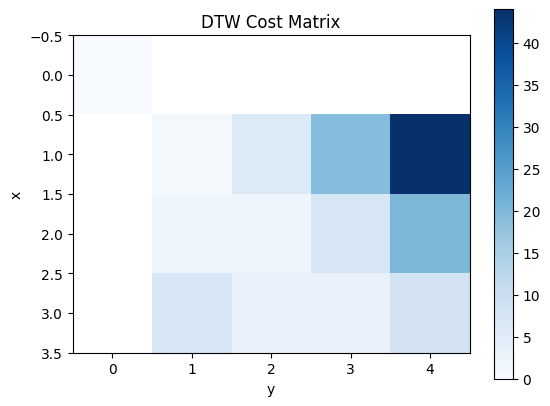

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Example: 3 points in 2D space
x = np.array([[1.0, 2.0],
              [2.0, 3.0],
              [3.0, 4.0]])

y = np.array([[2.0, 2.0],
              [3.0, 3.0],
              [4.0, 4.0],
              [5.0, 5.0]])

# Run DTW
dist, D = dynamic_time_warping(x, y)
print("DTW Distance:", dist)
print("Cost Matrix D:\n", D)

# Replace large values (e.g., sys.float_info.max) with NaN for safe plotting
safe_D = np.where(D > 1e6, np.nan, D)

# Plot safely
plt.imshow(safe_D, interpolation='nearest', cmap='Blues')
plt.title('DTW Cost Matrix')
plt.colorbar()
plt.xlabel('y')
plt.ylabel('x')
plt.show()
